## Import data

In [1]:
import pandas as pd
import numpy as np
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
train_df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [4]:
train_df['author'].value_counts() / len(train_df)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

## Preprocessing
Credit: https://www.kaggle.com/code/sandpiturtle/eda-fe-nb-xgb/notebook

In [5]:
import spacy
import nltk

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
# Define function used to replace named entities with ent__ORG
def replace_ents(doc):
    prefix = 'ent__'
    text = str(doc.doc)
    for ent in doc.ents:
        text = text.replace(ent.orth_, prefix + ent.label_)
    return text

Define func to preprocess text data. Here I am doing the following:

- Parsing text with spaCy
- Handcrafting new features identifying number of:
    - characters
    - words
    - punctuation characters
    - named entities
    - noun chunks
    - unique words
    - stop words
    - characters by word
- Replace named entities with tags like 'ent_ORG'
- Lemmatize
- Delete stopwords
- Calculating a general sentiment score

I leave 3 different versions (untouched, cleaned, entities replaced) of text in order to try which fits best with CV.

British-American-ness only has 32 training examples where their values were greater than 0, so this was ignored.


In [8]:
def preprocess(df):
    print('Started parsing...')
    doc = df.text.apply(nlp)
    print('Text parsed')
    
    df['n_char']   = df.text.apply(len)
    df['n_words']  = doc.apply(lambda x: len([t for t in x if not t.is_punct]))
    df['n_punct']  = doc.apply(lambda x: len([t for t in x if t.is_punct]))
    df['n_ents']   = doc.apply(lambda x: len(x.ents))
    df['n_chunks'] = doc.apply(lambda x: len(list(x.noun_chunks)))
    df['n_unique_words'] = doc.apply(lambda x: len(set([t.lower_ for t in x if not t.is_punct])))
    df['n_stop_words']   = doc.apply(lambda x: len([t for t in x if t.is_stop]))
    df['char_by_word']   = doc.apply(lambda x: np.mean([len(t.orth_) for t in x if not t.is_punct]))    
    print('Features created')
    
    df['text_ent_repl'] = doc.apply(replace_ents)
    print('Entities replaced')
    
    clean_and_lemmatize = lambda x: ' '.join([t.lemma_ for t in x if not t.is_punct and not t.is_stop])
    df['text_cleaned'] = doc.apply(clean_and_lemmatize)
    print('Text cleaned')

In [9]:
%%time
preprocess(train_df)

Started parsing...
Text parsed
Features created
Entities replaced
Text cleaned
CPU times: user 2min 15s, sys: 2.43 s, total: 2min 17s
Wall time: 2min 19s


In [10]:
%%time
preprocess(test_df)

Started parsing...
Text parsed
Features created
Entities replaced
Text cleaned
CPU times: user 54 s, sys: 726 ms, total: 54.7 s
Wall time: 55.1 s


In [11]:
from nltk.corpus import sentiwordnet as swn
from pywsd import disambiguate
# nltk.download('sentiwordnet')

Warming up PyWSD (takes ~10 secs)... took 4.808192014694214 secs.


In [12]:
%%time
sentiments = []
docs = nlp.pipe(train_df['text'], disable=['ner'])

for doc in docs:
    sentiment = 0
    for sentence in doc.sents:
        for word, sysnet in disambiguate(sentence.text):
            if sysnet is not None:
                sysnet_senti = swn.senti_synset(sysnet.name())
                sentiment += sysnet_senti.pos_score()
                sentiment -= sysnet_senti.neg_score()
    sentiments.append(sentiment)
train_df['sentiment'] = pd.Series(sentiments)

CPU times: user 2min 49s, sys: 16.9 s, total: 3min 6s
Wall time: 3min 9s


In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
import string
from nltk import word_tokenize

class CurrentWordsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        nlp = spacy.load("en_core_web_sm")
        self.words = {word: 1 for word in nlp.vocab.strings}
        return self

    def transform(self, X, y=None):
        count = []

        for sentence in X:
            current_count = 0
            words = word_tokenize(re.sub('[%s]' % re.escape(string.punctuation), '', sentence.lower()))

            for word in words:
                if self.words.get(word, 0) == 1:
                    current_count += 1/len(words)

            count.append(current_count)

        return pd.DataFrame(count)

In [14]:
current_words = CurrentWordsTransformer()
current_words_features = current_words.fit_transform(train_df['text'])
train_df['how_current'] = current_words_features.iloc[:, 0]

In [15]:
train_df.head()

,id,text,author,n_char,n_words,n_punct,n_ents,n_chunks,n_unique_words,n_stop_words,char_by_word,text_ent_repl,text_cleaned,sentiment,how_current
0,id26305,"This process, however, afforded me no means of...",EAP,231,41,7,0,11,35,26,4.487805,"This process, however, afforded me no means of...",process afford means ascertain dimension dunge...,1.375,0.975610
1,id17569,It never once occurred to me that the fumbling...,HPL,71,14,1,0,4,14,10,4.071429,It never once occurred to me that the fumbling...,occur fumbling mere mistake,-0.875,0.928571
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,36,5,0,11,32,17,4.444444,"In his left hand was a gold snuff box, from wh...",left hand gold snuff box caper hill cut manner...,0.625,0.916667
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,34,4,3,9,31,14,4.970588,How lovely is spring As we looked from ent__OR...,lovely spring look Windsor Terrace sixteen fer...,0.375,1.000000
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,27,4,0,7,25,14,5.333333,"Finding nothing else, not even gold, the Super...",find gold Superintendent abandon attempt perpl...,-0.500,1.000000


## Exploratory Data Analysis
Credit: https://www.kaggle.com/code/sandpiturtle/eda-fe-nb-xgb/notebook

Note: Sample size is likely not large enough to truly represent the characteristics of our authors' writings. I.e., below we might find in this dataset that MWS generally write longer sentences than the rest of the authors, always think: is that true in the real world? Or in other words if we were able to collect everything all three authors have ever written and do the same comparison, will we still observe the same phenomenon of MWS writing longer sentences? If eventually we decide to use sentence length as a feature, this will affect our model's ability to predict with real world data.

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

In [17]:
eap = train_df[train_df['author'] == 'EAP']
mws = train_df[train_df['author'] == 'MWS']
hpl = train_df[train_df['author'] == 'HPL']

### Sentence Length
Is there a difference in sentence length amongst the authors?

In [18]:
sns.set()

In [19]:
def drop_outliers(s):
    med = s.mean()
    std = s.std()
    return s[(med - 3*std <= s) & (s <= med + 3*std)]

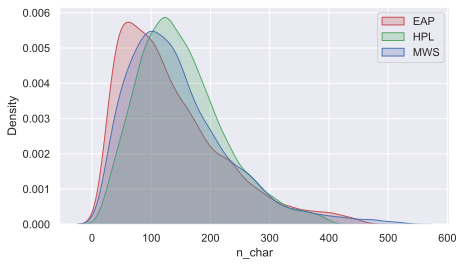

In [20]:
f, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(drop_outliers(eap.n_char), shade=True, color="r");
sns.kdeplot(drop_outliers(hpl.n_char), shade=True, color="g");
sns.kdeplot(drop_outliers(mws.n_char), shade=True, color="b");
ax.legend(labels=['EAP', 'HPL', 'MWS']);

HPL sentences seem a bit longer than the rest, EAP's a bit shorter. This feature might be useful in helping us distinguish the authors.

### Punctuation

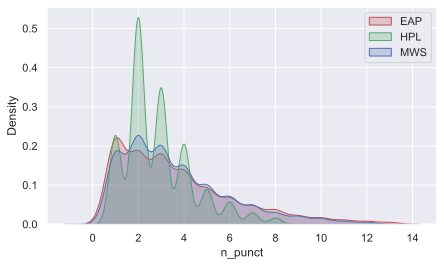

In [21]:
f, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(drop_outliers(eap.n_punct), shade=True, color="r");
sns.kdeplot(drop_outliers(hpl.n_punct), shade=True, color="g");
sns.kdeplot(drop_outliers(mws.n_punct), shade=True, color="b");
ax.legend(labels=['EAP', 'HPL', 'MWS']);

Here HPL's punctuation distribution is different from others

### Sentiment

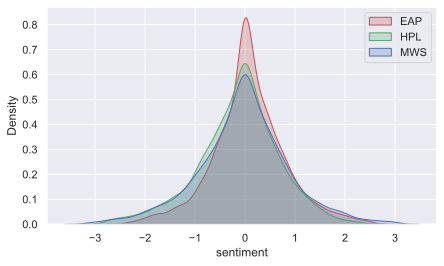

In [22]:
f, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(drop_outliers(eap.sentiment), shade=True, color="r");
sns.kdeplot(drop_outliers(hpl.sentiment), shade=True, color="g");
sns.kdeplot(drop_outliers(mws.sentiment), shade=True, color="b");
ax.legend(labels=['EAP', 'HPL', 'MWS']);

Sentiment distribution seem to be similar for all authors, with EAP slightly more neutral

## Model Training

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [24]:
y = train_df['author']

In [25]:
def get_log_loss(model, train, test):
    scores = cross_val_score(model, train, test, cv=10, n_jobs=-1, scoring='neg_log_loss')
    print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

### Count Vectorised

#### Cleaned Text

In [26]:
cv = CountVectorizer(ngram_range=(1, 2))
X = cv.fit_transform(train_df.text_cleaned)
get_log_loss(MultinomialNB(), X, y)

LogLoss: 0.460 +- 0.045


In [27]:
get_log_loss(LogisticRegression(max_iter=1000), X, y)

LogLoss: 0.498 +- 0.032


#### Text with Entities Replaced

In [28]:
cv = CountVectorizer(ngram_range=(1, 2))
X = cv.fit_transform(train_df.text_ent_repl)
get_log_loss(MultinomialNB(), X, y)

LogLoss: 0.698 +- 0.067


In [29]:
get_log_loss(LogisticRegression(max_iter=1000), X, y)

LogLoss: 0.489 +- 0.020


### TF-IDF

#### Cleaned Text

In [30]:
tfidf_v = TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True)
X = tfidf_v.fit_transform(train_df.text_cleaned)
get_log_loss(MultinomialNB(), X, y)

LogLoss: 0.588 +- 0.015


In [31]:
get_log_loss(LogisticRegression(max_iter=1000), X, y)

LogLoss: 0.561 +- 0.022


#### Text with Entities Replaced

In [32]:
tfidf_v = TfidfVectorizer(ngram_range=(1,1), sublinear_tf=True)
X = tfidf_v.fit_transform(train_df.text_ent_repl)
get_log_loss(MultinomialNB(), X, y)

LogLoss: 0.638 +- 0.014


In [33]:
get_log_loss(LogisticRegression(max_iter=1000), X, y)

LogLoss: 0.561 +- 0.013


### Meta Features Only

In [34]:
import xgboost as xgb
import lightgbm as lgb

In [35]:
X_meta = train_df.drop(['id', 'text', 'text_cleaned', 'text_ent_repl', 'author'], axis=1)

#### LGBM
Light Gradient Boosting Machines

In [36]:
lgbc = lgb.LGBMClassifier(objective='multiclass', n_estimators=100)
get_log_loss(lgbc, X_meta, y)

LogLoss: 0.935 +- 0.017


#### XGBoost

In [37]:
author_encoding = {
    'EAP': 0,
    'MWS': 1,
    'HPL': 2
}

y_encoded = [author_encoding[auth] for auth in y]

xgbc = xgb.XGBClassifier(objective='multi:softprob', n_estimators=200)
get_log_loss(xgbc, X_meta, y_encoded)

LogLoss: 0.986 +- 0.026


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

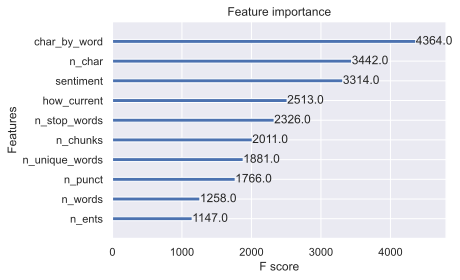

In [38]:
xgbc.fit(X_meta, y_encoded)
xgb.plot_importance(xgbc)

### Stacking Features
We select the most important features and use our base model (NB) to make classifications. We then use these classifications as features for our LGBM and XGBoost classifiers.

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [40]:
def add_prob_features(vectorizer, col, model, prefix, cv=5):
    vectorizer.fit(pd.concat([train_df[col], test_df[col]]))
    X = vectorizer.transform(train_df[col])
    X_test = vectorizer.transform(test_df[col])
    
    cv_scores = []
    pred_test = 0
    pred_train = np.zeros([train_df.shape[0], 3])
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=123)
    
    print('CV started')
    for train_index, dev_index in kf.split(X, y):
        X_train, X_dev = X[train_index], X[dev_index]
        y_train, y_dev = y[train_index], y[dev_index]
        
        model.fit(X_train, y_train)
        pred_dev   = model.predict_proba(X_dev)
        pred_test += model.predict_proba(X_test)
    
        pred_train[dev_index, :] = pred_dev
        cv_scores.append(metrics.log_loss(y_dev, pred_dev))
        print('.', end='')
        
    print('')
    print("Mean CV LogLoss: %.3f" % (np.mean(cv_scores)))
    pred_test /= cv

    train_df[prefix+'eap'] = pred_train[:, 0]
    train_df[prefix+'hpl'] = pred_train[:, 1]
    train_df[prefix+'mws'] = pred_train[:, 2]
    
    test_df[prefix+'eap'] = pred_test[:, 0]
    test_df[prefix+'hpl'] = pred_test[:, 1]
    test_df[prefix+'mws'] = pred_test[:, 2]

In [41]:
vectorizer = CountVectorizer(
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2), stop_words='english'
)
add_prob_features(vectorizer, 'text', MultinomialNB(), 'nb_ctv_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.434


In [42]:
vectorizer = TfidfVectorizer(
    token_pattern=r'\w{1,}', ngram_range=(1, 1), 
    use_idf=True, smooth_idf=True, sublinear_tf=True,
)
add_prob_features(vectorizer, 'text_cleaned', MultinomialNB(), 'nb_tfv_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.578


In [43]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 5), analyzer='char'
)
add_prob_features(vectorizer, 'text', MultinomialNB(), 'nb_char_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.733


In [44]:
vectorizer = CountVectorizer(
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2), stop_words='english'
)
add_prob_features(vectorizer, 'text_ent_repl', MultinomialNB(), 'nb_ent_', cv=40)

CV started
........................................
Mean CV LogLoss: 0.517


In [45]:
X = train_df.drop(['id', 'text', 'text_cleaned', 'text_ent_repl', 'author'], axis=1)

In [ ]:
lgbc = lgb.LGBMClassifier(objective='multiclass', n_estimators=150, num_leaves=10)
scores = cross_val_score(lgbc, X, y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

In [48]:
xgbc = xgb.XGBClassifier(objective='multi:softprob', n_estimators=150)
scores = cross_val_score(xgbc, X, y_encoded, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.395 +- 0.032


## Evaluation